In [ ]:
''' compute distance for each SD intercept, adjust wind to 10m using COARE3.6, 
and compute wind power by water current velocity for now (for simplicity) 

Note for getting non-NaNs values from COARE3.6 function "coare36vn_zrf_et"
- Do not assign NaN values to unknown variables
- can assign zi btw 600 & 300 makes minimal difference in U10, Cd10
- can assign LW_dn btw 350 & 0 makes minimal difference in U10, Cd10
- assign SW_dn = 0 makes almost no difference in U10, Cd10
- assign rain to 0 makes to difference in U10, Cd10
- assign Ss to 0 makes minimal difference in U10, Cd10
'''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
sys.path.insert(0, path_nhchi)
from windstr import Cd_e13_CH2020, wind_adj2height_PL
from coare36vnWarm_et import coare36vnWarm_et
from coare36vn_zrf_et import coare36vn_zrf_et # output index 1: wind stress, 12: Cd (at height zu), 32: U10, 34: Cdn_10
from compute_distance import distance
from convert_time import datetime_to_yearday

In [2]:
''' Read the time range for SD intercept file '''
year = '2022'
path = '/Users/chi/Documents/projects/sd-ni-wp/SD_wp_TCs/'
fn_intercept = 'time-range_SD_intercept(lt500km)_TCs_NA_'+year+'.txt'
TC_intercept = np.genfromtxt(path+fn_intercept, delimiter=' ',skip_header=1, usecols=(0,1), dtype=str)
ds_intercept = np.genfromtxt(path+fn_intercept, delimiter=' ',skip_header=1, usecols=(2,3,4), dtype=float)
print(type(TC_intercept),TC_intercept[0])
print(type(ds_intercept),ds_intercept[0])
''' settings '''
path_met = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
''' Read the SD-intercept TCs tracks (interp) '''
path = '/Users/chi/Documents/projects/sd-ni-wp/SD_wp_TCs/data_SD_TC-intercept/'
fn_SD_track = 'SD_intercept_TCs_tracks(interp)_NA_'+year+'.txt'
SD_TC_track_data = np.genfromtxt(path+fn_SD_track, delimiter=' ',skip_header=2, usecols=(0,7),dtype=str)
track_data = np.genfromtxt(path+fn_SD_track, delimiter=' ',skip_header=2, usecols=(1,6,9,10,11,12,13,14),dtype=float)
print('SD_TC track data:',SD_TC_track_data[0])
print('track_data:',track_data[0])

<class 'numpy.ndarray'> ['EARL' '1031']
<class 'numpy.ndarray'> [1.66234170e+09 1.66235268e+09 4.97900000e+02]
SD_TC track data: ['1031' 'EARL']
track_data: [ 1.66234170e+09  4.99999309e+02 -6.50404117e+01  2.00179216e+01
  0.00000000e+00  4.00000000e+00  3.05000000e+02  2.00000000e+00]


In [3]:
''' plot (1) timeseries of SD measurements during TC intercepts & 
            (2) TC info (distance, category, SD quadrant) '''
vars_met_str = ['longitude','latitude','TEMP_AIR_MEAN','RH_MEAN','BARO_PRES_MEAN','TEMP_SBE37_MEAN','SAL_SBE37_MEAN',\
                'WAVE_SIGNIFICANT_HEIGHT','PAR_AIR_MEAN','UWND_MEAN','VWND_MEAN']
vars_fill_str = ['longitude','latitude','TEMP_AIR_MEAN','RH_MEAN','BARO_PRES_MEAN','TEMP_SBE37_MEAN','SAL_SBE37_MEAN',\
                 'SW_dn']
vals_fill = [-65,25,27,80,1000,28,34,800]
irow_plot = [0,1,2,3,4,5,6,7,8,9,9]
nrow = irow_plot[-1]+5
ncol = 1
cols_sshs = ['rosybrown','rosybrown','rosybrown','rosybrown','navy','blue','forestgreen','gold','orange','red','brown']
strs_sshs = ['Others','TD','TS','CAT1','CAT2','CAT3','CAT4','CAT5']

for irow, SDname in enumerate( TC_intercept[:,1] ):
    TCname = TC_intercept[irow,0]
    print(year+'-SD'+SDname+' intercept '+TCname)
    ''' Read wind & met data (1-min) '''
    ds_met = nc.Dataset(path_met+'airsea-raw-merge-'+year+'-SD'+SDname+'.nc')
    tstamp_met = np.array([ (datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=item)).timestamp() \
                           for item in np.ma.getdata(ds_met.variables['time'][:]) ])
    imet = np.where( (tstamp_met>= ds_intercept[irow,0]) & (tstamp_met<= ds_intercept[irow,1]) )[0]
    dtime_met_plot = np.array([datetime.datetime.fromtimestamp(item) for item in tstamp_met[imet]])
    tstamp_met = tstamp_met[imet]
    _, jday_met = datetime_to_yearday( dtime_met_plot )
    print('tstamp_met.shape=',tstamp_met.shape, dtime_met_plot[0],dtime_met_plot[-1])
    ''' Read adcp data (5-min) '''
    # if os.path.isfile(path_adcp+'adcp-raw-merge-'+year+'-SD'+SDname+'.nc'):
    #     ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+SDname+'.nc')
    #     tstamp_adcp = np.array([ (datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=item)).timestamp() \
    #                         for item in np.ma.getdata(ds_adcp.variables['time'][:]) ])
    #     iadcp = np.where( (tstamp_adcp>= ds_intercept[irow,0]) & (tstamp_adcp<= ds_intercept[irow,1]) )[0]
    #     dtime_adcp_plot = np.array([datetime.datetime.fromtimestamp(item) for item in tstamp_adcp[iadcp]])
    #     tstamp_adcp = tstamp_adcp[iadcp]
    #     if len(iadcp)> 0:
    #         print('tstamp_adcp.shape=',tstamp_adcp.shape, dtime_adcp_plot[0],dtime_adcp_plot[-1])
    #     ucur = np.ma.getdata( ds_adcp.variables['vel_east'][:] )[iadcp,0]
    #     vcur = np.ma.getdata( ds_adcp.variables['vel_north'][:] )[iadcp,0]
    #     ds_adcp.close()
    
    ''' first, read SD alongtrack met-ocean time series '''
    for v, var in enumerate( vars_met_str ):
        data = np.ma.getdata( ds_met.variables[var][:] )[imet]
        if var == 'PAR_AIR_MEAN':
            data = data/2.4 # W/m^2
            exec('SW_dn=data')
        else:
            exec(var+'=data')
    ds_met.close()
    ''' compute largest distance up to from begin of the intercept '''
    # distMAX = np.zeros( tstamp_met.shape )
    # for k in range( 0,len(distMAX) ):
    #     dist_all = []
    #     lon_comp = longitude[:k]
    #     lat_comp = latitude[:k]
    #     for i in range( len(lon_comp) ):
    #         for j in range( i+1,len(lon_comp) ):
    #             dist_all.append( distance(lat_comp[i],lon_comp[i],lat_comp[j],lon_comp[j]) )
    #     if len( dist_all )> 0:
    #         distMAX[k] = np.nanmax( dist_all )
    ''' Fill met-ocean data gaps '''
    print('List of filled variables with NaNs')
    iwnd = ~np.isnan( UWND_MEAN )
    for v, var in enumerate( vars_fill_str ):
        isok = ~np.isnan( eval(var) )
        data_fill = np.interp( tstamp_met[iwnd], tstamp_met[isok], eval(var+'[isok]') )
        if np.sum( ~np.isnan(data_fill) ) == 0:
            for k, var_fill_k in enumerate( vars_fill_str ):
                if var == var_fill_k:
                    data_fill = vals_fill[k]*np.ones( data_fill.shape )
                    print(var+'(all NaNs) is replaced by all',vals_fill[k])
        exec( var+'_fill=data_fill')
                
    ''' Then, adjust wind to 10 m '''
    u3_5m = np.sqrt( np.square(UWND_MEAN) + np.square(VWND_MEAN) )[iwnd]
    ones = np.ones( jday_met.shape )[iwnd]
    z_inst = np.array([3.5])
    # res = coare36vnWarm_et(Jd=jday_met[iwnd],U=u3_5m, Zu=z_inst, Tair=TEMP_AIR_MEAN_fill, Zt=z_inst, RH=RH_MEAN_fill, Zq=z_inst, P=BARO_PRES_MEAN_fill, \
    #                        Tsea=TEMP_SBE37_MEAN_fill, SW_dn=SW_dn_fill, LW_dn=350*ones, \
    #                        Lat=latitude_fill, Lon=longitude_fill, Zi=np.nan*ones, Rainrate=0*ones, Ts_depth=0.5*ones, \
    #                         Ss=SAL_SBE37_MEAN_fill, cp=None, sigH=None, zrf_u = 10.0,zrf_t = 10.0,zrf_q = 10.0)
    res = coare36vn_zrf_et(u=np.abs(UWND_MEAN[iwnd]), zu=z_inst, t=TEMP_AIR_MEAN_fill, zt=z_inst, rh=RH_MEAN_fill, zq=z_inst, P=BARO_PRES_MEAN_fill, \
                           ts=TEMP_SBE37_MEAN_fill, sw_dn=SW_dn_fill, lw_dn=350*ones, \
                            lat=latitude_fill, lon=longitude_fill, jd =jday_met[iwnd], zi=600*ones, rain=0*ones, \
                            Ss=SAL_SBE37_MEAN_fill, zrf_u = 10.0, zrf_t = 10.0,zrf_q = 10.0)
    
    ''' add TC info - find the rows in SD_intercept_TCs_tracks(interp)_NA file '''
    # irow_SD_TC = np.where( (SD_TC_track_data[:,0] == SDname) & (SD_TC_track_data[:,1] == TCname) )[0]
    # dtime_track_data = np.array([datetime.datetime.fromtimestamp(item) for item in track_data[irow_SD_TC,0]])
    ''' +++++ plot distance to best track '''
    ''' +++++ plot interpolated best track longitude & latitude '''
    ''' +++++ plot TC sshs '''
    ''' +++++ plot SD quadrant relative to storm center '''
    
    ''' sub figure settings '''
    ''' save figure '''
    if irow > 1:
        break
    # plt.savefig('timeseries_'+year+'-SD'+SDname+'_lt500km-to-'+TCname+'.png')
    # break

2022-SD1031 intercept EARL
tstamp_met.shape= (184,) 2022-09-04 18:35:00 2022-09-04 21:38:00
List of filled variables with NaNs
2022-SD1040 intercept EARL


/Users/chi/Documents/projects/analytical-tools/py_nhchi/coare36vn_zrf_et.py:750: RuntimeWarning: invalid value encountered in power
  psi = - ((1 + 0.6667 * zeta) ** 1.5 + np.multiply(0.6667 * (zeta - 14.28),np.exp(- dzeta)) + 8.525)
/Users/chi/Documents/projects/analytical-tools/py_nhchi/coare36vn_zrf_et.py:715: RuntimeWarning: invalid value encountered in power
  wc_frac = 0.00073 * (U10N - 2) ** 1.43


tstamp_met.shape= (4629,) 2022-09-03 14:56:00 2022-09-06 20:04:00
List of filled variables with NaNs
2022-SD1031 intercept FIONA


/Users/chi/Documents/projects/analytical-tools/py_nhchi/coare36vn_zrf_et.py:442: RuntimeWarning: divide by zero encountered in true_divide
  gf = ut / du
/Users/chi/Documents/projects/analytical-tools/py_nhchi/coare36vn_zrf_et.py:538: RuntimeWarning: divide by zero encountered in true_divide
  gf = ut / du
/Users/chi/Documents/projects/analytical-tools/py_nhchi/coare36vn_zrf_et.py:648: RuntimeWarning: divide by zero encountered in true_divide
  gf = ut / du


tstamp_met.shape= (4320,) 2022-09-17 01:37:00 2022-09-20 01:36:00
List of filled variables with NaNs


In [10]:
print(res.shape)
print(np.sum(np.isnan(res))/len(res.flatten())*100,'% is NaN')

(4320, 50)
0.0 % is NaN


longitude
number of NaNs 0


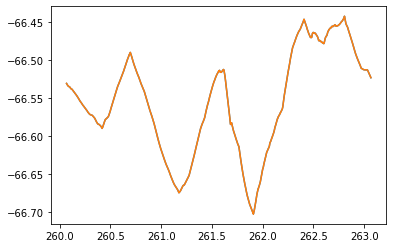

latitude
number of NaNs 0


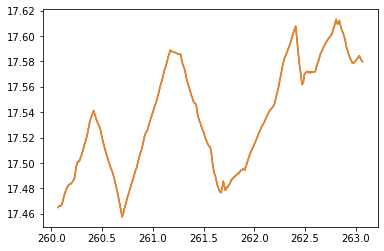

TEMP_AIR_MEAN
number of NaNs 0


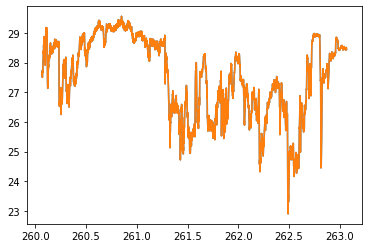

RH_MEAN
number of NaNs 0


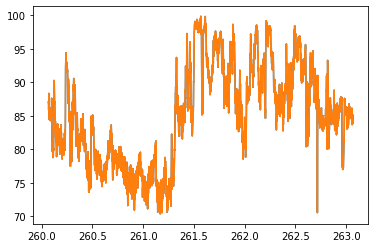

BARO_PRES_MEAN
number of NaNs 0


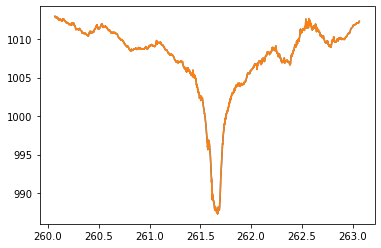

TEMP_SBE37_MEAN
number of NaNs 0


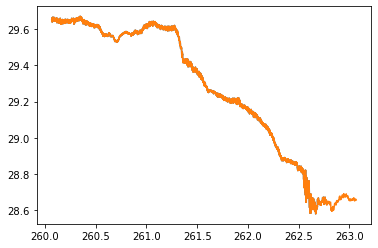

SAL_SBE37_MEAN
number of NaNs 0


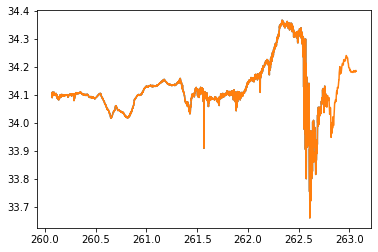

SW_dn
number of NaNs 0


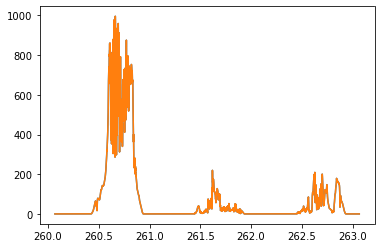

In [5]:
from time import sleep
for v, var in enumerate( vars_fill_str ):
    print(var)
    plt.clf()
    plt.plot(jday_met[iwnd],eval(var))
    if var+'_fill' in locals():
        print('number of NaNs',np.sum(np.isnan(eval(var+'_fill'))))
        plt.plot(jday_met[iwnd],eval(var+'_fill'))
        plt.show()
        # sleep(2)

0 NaNs


/Users/chi/Documents/projects/analytical-tools/py_nhchi/coare36vn_zrf_et.py:750: RuntimeWarning: invalid value encountered in power
  psi = - ((1 + 0.6667 * zeta) ** 1.5 + np.multiply(0.6667 * (zeta - 14.28),np.exp(- dzeta)) + 8.525)
/Users/chi/Documents/projects/analytical-tools/py_nhchi/coare36vn_zrf_et.py:715: RuntimeWarning: invalid value encountered in power
  wc_frac = 0.00073 * (U10N - 2) ** 1.43


(4320, 50) 0.0 % NaNs


<Figure size 432x288 with 0 Axes>

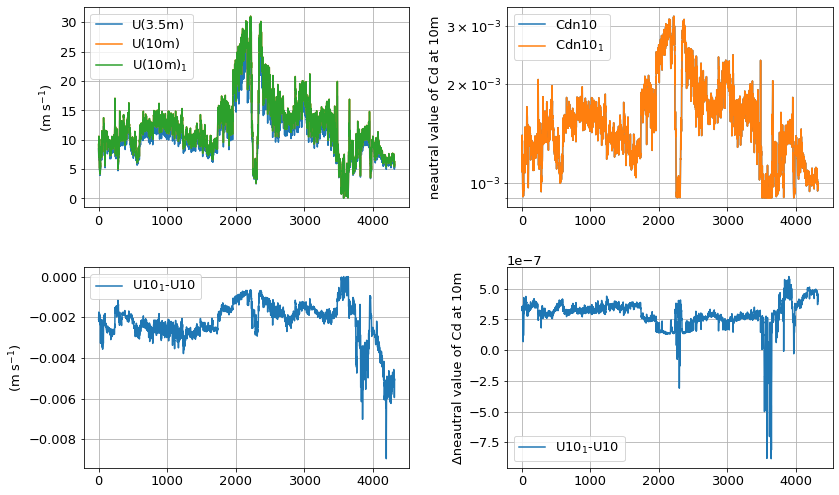

In [12]:
u = u3_5m[iwnd]
zu = np.array([3.5])
test = np.ones( (len(u),14) )
print(np.sum(np.isnan(u)),'NaNs')
test_out = coare36vn_zrf_et(u,zu,TEMP_AIR_MEAN_fill[iwnd],zu,RH_MEAN_fill[iwnd],zu,BARO_PRES_MEAN_fill[iwnd],TEMP_SBE37_MEAN_fill[iwnd],\
                            SW_dn_fill[iwnd],350*test[:,0],longitude_fill[iwnd],latitude_fill[iwnd],jday_met[iwnd],600*ones,0*ones,SAL_SBE37_MEAN_fill[iwnd])
test_out1 = coare36vn_zrf_et(u,zu,TEMP_AIR_MEAN_fill[iwnd],zu,RH_MEAN_fill[iwnd],zu,BARO_PRES_MEAN_fill[iwnd],TEMP_SBE37_MEAN_fill[iwnd],\
                            SW_dn_fill[iwnd],350*test[:,0],longitude_fill[iwnd],latitude_fill[iwnd],jday_met[iwnd],600*ones,0*ones,0*ones)
print(test_out.shape, np.sum(np.isnan(test_out))/len(test_out.flatten())*100,'% NaNs')
nrow = 2; ncol = 2
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(nrows=nrow,ncols=ncol)
fig.set_size_inches(13, 8)
''' plot u vs. u10'''
plt.subplot(nrow,ncol,1)
plt.plot(u,label='U({:.1f}m)'.format(zu[0]))
plt.plot(test_out[:,32],label='U(10m)')
plt.plot(test_out1[:,32],label='U(10m)$_1$')
plt.grid(which='both',axis='both')
plt.ylabel('(m s$^{-1}$)')
plt.legend()
''' plot u10 difference '''
plt.subplot(nrow,ncol,3)
plt.plot(test_out1[:,32]-test_out[:,32],label='U10$_1$-U10')
plt.grid(which='both',axis='both')
plt.ylabel('(m s$^{-1}$)')
plt.legend()
''' plot Cd '''
plt.subplot(nrow,ncol,2) 
plt.semilogy(test_out[:,34],label='Cdn10')
plt.semilogy(test_out1[:,34],label='Cdn10$_1$')
plt.grid(which='both',axis='both')
plt.ylabel('neautral value of Cd at 10m')
plt.legend()
''' plt Cd difference '''
plt.subplot(nrow,ncol,4)
plt.plot(test_out1[:,34]-test_out[:,34],label='U10$_1$-U10')
plt.grid(which='both',axis='both')
plt.ylabel('\u0394neautral value of Cd at 10m')
plt.legend()

''' settings '''
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.3)
